# Classifying Planets

## Introduction

In this classification problem, we embark on a journey where we are presented with a synthetic dataset of planets and moons of our solar system. Our mission is clear: **classify from an image the planet or moon**.

In [14]:
import os
import random
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

In [15]:
# Set the random seed for reproducibility
seed = 77

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.random.set_seed(seed)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

## Load the data

In [16]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

In [17]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "data/raw/.",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 13901 files belonging to 6 classes.


## Exploring the data

In [18]:
print('Data shape:', dataset.element_spec[0].shape)
print('Data type:', dataset.element_spec[0].dtype)
print('Label shape:', dataset.element_spec[1].shape)
print('Label type:', dataset.element_spec[1].dtype)

labels = dataset.class_names

# Print the labels
print("Labels:")
for i, label in enumerate(labels):
    print(f"{i:4}: {label}")


Data shape: (None, 256, 256, 3)
Data type: <dtype: 'float32'>
Label shape: (None,)
Label type: <dtype: 'int32'>
Labels:
   0: cardboard
   1: glass
   2: metal
   3: paper
   4: plastic
   5: trash


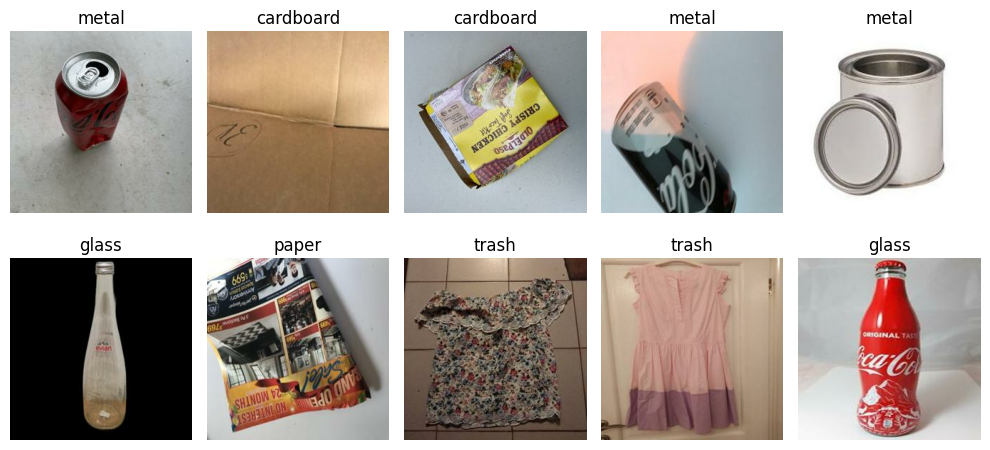

In [19]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[label_idxs[i].numpy()])
        plt.axis("off")

## Preparing the data

The following steps are performed to prepare the data:

- Shuffling the data
- Splitting the data into training and validation sets
- Normalizing the data

In [20]:
ds_train, ds_test = tf.keras.utils.image_dataset_from_directory(
    "data/raw/.",
    labels="inferred",
    label_mode="int",
    color_mode="rgb", #grayscale
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="both",
)

Found 13901 files belonging to 6 classes.
Using 11121 files for training.
Using 2780 files for validation.


2025-12-06 21:12:16.598162: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


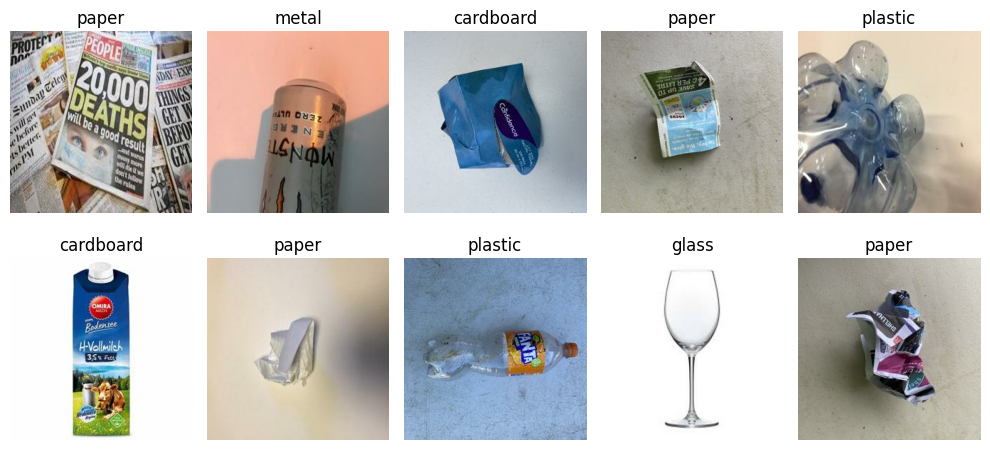

In [21]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds_train.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[label_idxs[i].numpy()])
        plt.axis("off")

In [22]:
# Normalize the data
normalization_layer = tf.keras.layers.Rescaling(
    1.0 / 255
)
ds_train = ds_train.map(lambda x, y: (normalization_layer(x), y))
ds_test = ds_test.map(lambda x, y: (normalization_layer(x), y))


## Training the model

In [23]:
from tensorflow.keras import regularizers

base_model = tf.keras.applications.MobileNetV2(
        input_shape=(256, 256, 3),
        include_top=False,
        weights='imagenet'
    )
    
base_model.trainable = True
    
model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='mish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(6, kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model.summary()

/tmp/ipykernel_13328/942286538.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 2,388,614 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [24]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 2,388,614 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

epochs = 25

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [26]:
model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_test,
    callbacks=[lr_scheduler, early_stopping, checkpoint]
)

Epoch 1/25
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 1.2694 - sparse_categorical_accuracy: 0.6223
Epoch 1: val_loss improved from None to 1.29811, saving model to best_model.keras
348/348 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - loss: 0.9225 - sparse_categorical_accuracy: 0.7580 - val_loss: 1.2981 - val_sparse_categorical_accuracy: 0.6417 - learning_rate: 1.0000e-04
Epoch 2/25
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.5197 - sparse_categorical_accuracy: 0.9060
Epoch 2: val_loss improved from 1.29811 to 1.12519, saving model to best_model.keras
348/348 ━━━━━━━━━━━━━━━━━━━━ 112s 321ms/step - loss: 0.4816 - sparse_categorical_accuracy: 0.9191 - val_loss: 1.1252 - val_sparse_categorical_accuracy: 0.7216 - learning_rate: 1.0000e-04
Epoch 3/25
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.3858 - sparse_categorical_accuracy: 0.9456
Epoch 3: val_loss improved from 1.12519 to 0.61743, saving model to best_model.keras
348/348 ━━━━━━━━━━━━━━━━━━━━ 109s 314ms/step - loss: 

## Model Evaluation

Evaluate the model on the validation set.

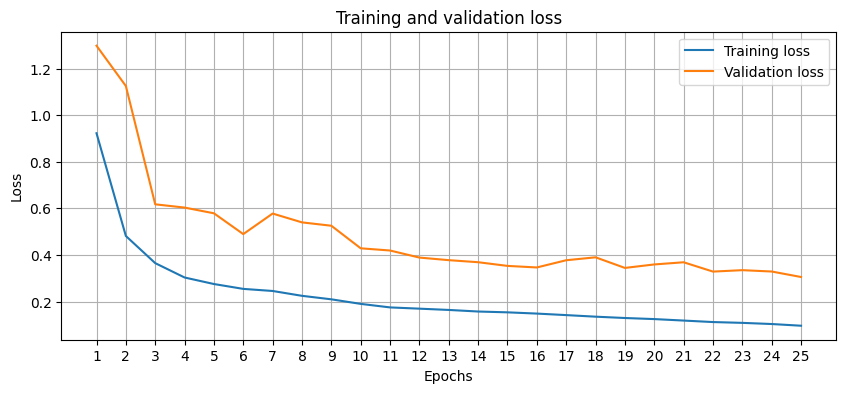

In [27]:
# Plot the training and validation loss
history = model.history.history
epochs = range(1, len(history["loss"]) + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, history["loss"], label="Training loss")
plt.plot(epochs, history["val_loss"], label="Validation loss")
plt.xticks(epochs)
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

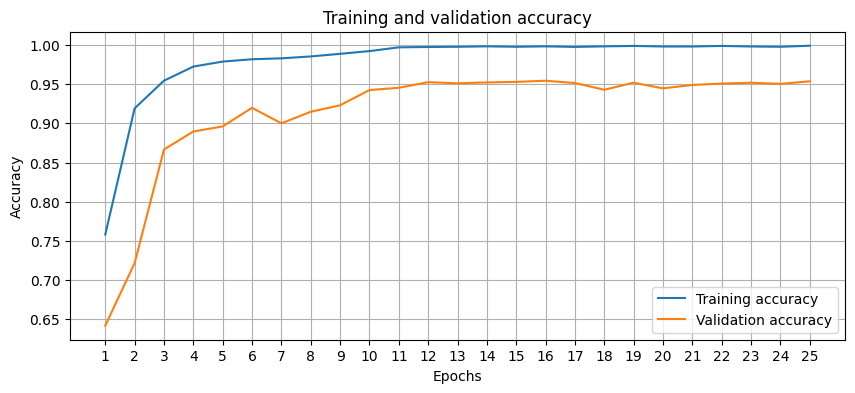

In [40]:
# Plot the training and validation sparse categorical accuracy
history = model.history.history
epochs = range(1, len(history["sparse_categorical_accuracy"]) + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, history["sparse_categorical_accuracy"], label="Training accuracy")
plt.plot(epochs, history["val_sparse_categorical_accuracy"], label="Validation accuracy")
plt.xticks(epochs)
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Print validation metrics
val_loss, val_acc = model.evaluate(ds_test)
print(f"Validation loss: {val_loss:.2f}")
print(f"Validation accuracy: {val_acc * 100:.2f}%")

87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.3055 - sparse_categorical_accuracy: 0.9536
Validation loss: 0.31
Validation accuracy: 95.36%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


2025-12-06 22:10:21.084897: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


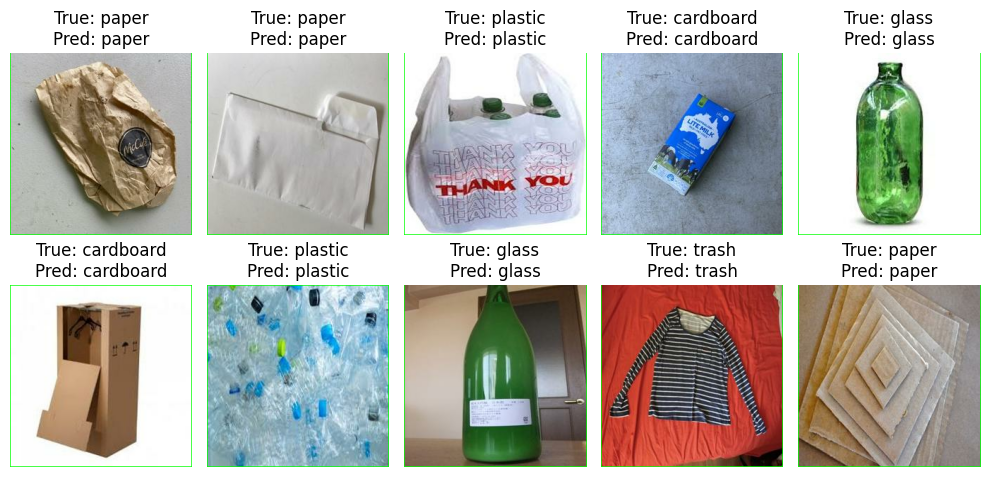

In [41]:
# Take 10 random images from the test set and show the model's predictions
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds_test.take(1):
    preds = model.predict(images)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        img = (images[i].numpy() * 255).astype("uint8")
        # Convert image to rgb if grayscale
        if img.shape[-1] == 1:
            img = np.squeeze(img, axis=-1)
            img = np.stack((img,) * 3, axis=-1)
        true_label = labels[label_idxs[i].numpy()]
        pred_label = labels[np.argmax(preds[i])]
        # Add red border if the prediction is wrong else add green border
        img = np.pad(img, pad_width=((1, 1), (1, 1), (0, 0)))
        if true_label != pred_label:
            img[0, :, 0] = 255  # Top border
            img[-1, :, 0] = 255  # Bottom border
            img[:, 0, 0] = 255  # Left border
            img[:, -1, 0] = 255  # Right border
        else:
            img[0, :, 1] = 255
            img[-1, :, 1] = 255
            img[:, 0, 1] = 255
            img[:, -1, 1] = 255

        plt.imshow(img)
        plt.title(f"True: {true_label}\n" f"Pred: {pred_label}")
        plt.axis("off")
plt.show()

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step


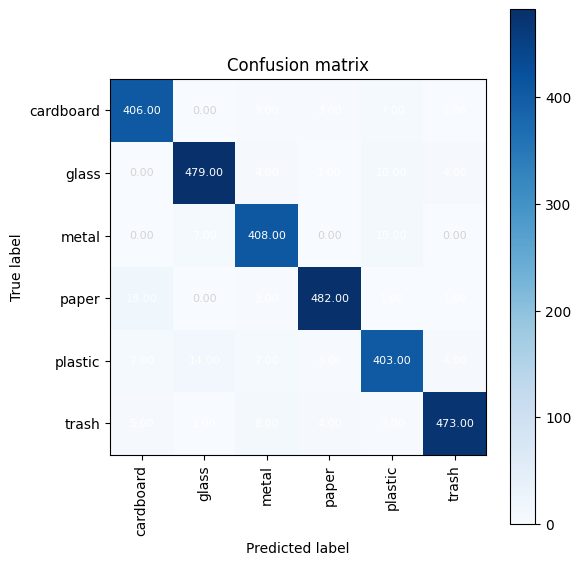

In [42]:
# Show confusion matrix of confidence per class for the test set
plt.figure(figsize=(6, 6), tight_layout=True)
preds = model.predict(ds_test)

conf_matrix = tf.math.confusion_matrix(
    labels=tf.concat([y for _, y in ds_test], axis=0),
    predictions=tf.argmax(preds, axis=1),
    num_classes=len(labels),
)

# Plot the confusion matrix
plt.imshow(conf_matrix, cmap="Blues")

# Plot cell values
for i in range(len(labels)):
    for j in range(len(labels)):
        value = conf_matrix[i, j].numpy()
        if value == 0:
            color = "lightgray"
        elif value > 0.5:
            color = "white"
        else:
            color = "black"
        plt.text(
            j,
            i,
            f"{value:.2f}",
            ha="center",
            va="center",
            color=color,
            fontsize=8,
        )

plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.show()

In [31]:
# Score accuracy, precision and f1-score of model on the test set
test_loss, test_acc = model.evaluate(ds_test)
print(f"Test loss: {test_loss:.2f}")
print(f"Test accuracy: {test_acc * 100:.2f}%")
from sklearn.metrics import precision_score, f1_score
y_true = tf.concat([y for _, y in ds_test], axis=0).numpy()
y_pred = tf.argmax(preds, axis=1).numpy()

# Report scikit-learn classification report
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
print("Classification Report:")
print(report)

87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.3055 - sparse_categorical_accuracy: 0.9536
Test loss: 0.31
Test accuracy: 95.36%
Classification Report:
{'cardboard': {'precision': 0.9311926605504587, 'recall': 0.9666666666666667, 'f1-score': 0.9485981308411215, 'support': 420.0}, 'glass': {'precision': 0.9560878243512974, 'recall': 0.9618473895582329, 'f1-score': 0.958958958958959, 'support': 498.0}, 'metal': {'precision': 0.9422632794457275, 'recall': 0.96, 'f1-score': 0.951048951048951, 'support': 425.0}, 'paper': {'precision': 0.9776876267748479, 'recall': 0.9544554455445544, 'f1-score': 0.9659318637274549, 'support': 505.0}, 'plastic': {'precision': 0.9285714285714286, 'recall': 0.9200913242009132, 'f1-score': 0.9243119266055045, 'support': 438.0}, 'trash': {'precision': 0.979296066252588, 'recall': 0.9574898785425101, 'f1-score': 0.9682702149437052, 'support': 494.0}, 'accuracy': 0.9535971223021583, 'macro avg': {'precision': 0.9525164809910581, 'recall': 0.953425117418813, 'f1-

In [32]:
report

{'cardboard': {'precision': 0.9311926605504587,
  'recall': 0.9666666666666667,
  'f1-score': 0.9485981308411215,
  'support': 420.0},
 'glass': {'precision': 0.9560878243512974,
  'recall': 0.9618473895582329,
  'f1-score': 0.958958958958959,
  'support': 498.0},
 'metal': {'precision': 0.9422632794457275,
  'recall': 0.96,
  'f1-score': 0.951048951048951,
  'support': 425.0},
 'paper': {'precision': 0.9776876267748479,
  'recall': 0.9544554455445544,
  'f1-score': 0.9659318637274549,
  'support': 505.0},
 'plastic': {'precision': 0.9285714285714286,
  'recall': 0.9200913242009132,
  'f1-score': 0.9243119266055045,
  'support': 438.0},
 'trash': {'precision': 0.979296066252588,
  'recall': 0.9574898785425101,
  'f1-score': 0.9682702149437052,
  'support': 494.0},
 'accuracy': 0.9535971223021583,
 'macro avg': {'precision': 0.9525164809910581,
  'recall': 0.953425117418813,
  'f1-score': 0.9528533410209493,
  'support': 2780.0},
 'weighted avg': {'precision': 0.9539256624773149,
  'rec

In [33]:
# data

from datetime import datetime 

now = datetime.now()

print("Current date and time:", now)

Current date and time: 2025-12-06 22:00:32.743034


In [34]:
from datetime import datetime
import pandas as pd

def push_scores_to_file(report : dict, dst : str):
    now = datetime.now()

    # si fichier n'existe pas, on ajoute l'entete
    if not Path(dst).is_file():
        with open(dst, 'a') as f:
            f.write("timestamp;accuracy;precision;recall;f1_score;support\n")
            f.close()

    with open(dst, 'a') as f:
        accuracy = report['accuracy']
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1_score = report['macro avg']['f1-score']
        support = report['macro avg']['support']
        f.write(f"{now};{accuracy};{precision};{recall};{f1_score};{support}\n")
        f.close()

    

In [35]:
classes = pd.read_csv('classes.txt', sep=";", header=None).values.tolist()
print(classes)

[['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']]


In [36]:
report['glass']['precision']

0.9560878243512974

In [37]:
def push_labels_score_to_file(report : dict, dst : str):
    now = datetime.now()
    classes = pd.read_csv('classes.txt', sep=";", header=None).values.tolist()[0]
    metrics = ['precision', 'recall', 'f1-score', 'support']

    # Générer l'en-tête dynamiquement
    if not Path(dst).is_file():
        header = "timestamp"
        for cls in classes:
            for metric in metrics:
                header += f";{cls}_{metric}"
        
        with open(dst, 'a') as f:
            f.write(header + "\n")
            f.close()

    # Écrire les données
    with open(dst, 'a') as f:
        row = f"{now}"
        for cls in classes:
            for metric in metrics:
                row += f";{report[cls][metric]}"
        f.write(row + "\n")

In [38]:
dst = './data/scores/training_scores.csv'
push_scores_to_file(report, dst)

In [39]:
dst = './data/scores/class_scores.csv'
push_labels_score_to_file(report, dst)